In [1]:
import argparse, os, sys, glob
import cv2
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext

from ldm.util import instantiate_from_config

from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

def numpy_to_pil(images):
    """
    Convert a numpy image or a batch of images to a PIL image.
    """
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]

    return pil_images


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)
    model.eval()
    return model

C:\Users\Alex_\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Alex_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Alex_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
parser = argparse.ArgumentParser()

parser.add_argument(
    "--prompt",
    type=str,
    nargs="?",
    default="a painting of a virus monster playing guitar",
    help="the prompt to render"
)
parser.add_argument(
    "--outdir",
    type=str,
    nargs="?",
    help="dir to write results to",
    default="outputs/txt2img-samples"
)
parser.add_argument(
    "--skip_grid",
    action='store_true',
    help="do not save a grid, only individual samples. Helpful when evaluating lots of samples",
)
parser.add_argument(
    "--skip_save",
    action='store_true',
    help="do not save individual samples. For speed measurements.",
)
parser.add_argument(
    "--ddim_steps",
    type=int,
    default=50,
    help="number of ddim sampling steps",
)
parser.add_argument(
    "--plms",
    action='store_true',
    help="use plms sampling",
)
parser.add_argument(
    "--laion400m",
    action='store_true',
    help="uses the LAION400M model",
)
parser.add_argument(
    "--fixed_code",
    action='store_true',
    help="if enabled, uses the same starting code across samples ",
)
parser.add_argument(
    "--ddim_eta",
    type=float,
    default=0.0,
    help="ddim eta (eta=0.0 corresponds to deterministic sampling",
)
parser.add_argument(
    "--n_iter",
    type=int,
    default=1,
    help="sample this often",
)
parser.add_argument(
    "--H",
    type=int,
    default=512,
    help="image height, in pixel space",
)
parser.add_argument(
    "--W",
    type=int,
    default=512,
    help="image width, in pixel space",
)
parser.add_argument(
    "--C",
    type=int,
    default=4,
    help="latent channels",
)
parser.add_argument(
    "--f",
    type=int,
    default=8,
    help="downsampling factor",
)
parser.add_argument(
    "--n_samples",
    type=int,
    default=3,
    help="how many samples to produce for each given prompt. A.k.a. batch size",
)
parser.add_argument(
    "--n_rows",
    type=int,
    default=0,
    help="rows in the grid (default: n_samples)",
)
parser.add_argument(
    "--scale",
    type=float,
    default=7.5,
    help="unconditional guidance scale: eps = eps(x, empty) + scale * (eps(x, cond) - eps(x, empty))",
)
parser.add_argument(
    "--from-file",
    type=str,
    help="if specified, load prompts from this file",
)
parser.add_argument(
    "--config",
    type=str,
    default="configs/stable-diffusion/v1-inference.yaml",
    help="path to config which constructs model",
)
parser.add_argument(
    "--ckpt",
    type=str,
    default="models/ldm/stable-diffusion-v1/model.ckpt",
    help="path to checkpoint of model",
)
parser.add_argument(
    "--seed",
    type=int,
    default=42,
    help="the seed (for reproducible sampling)",
)
parser.add_argument(
    "--precision",
    type=str,
    help="evaluate at this precision",
    choices=["full", "autocast"],
    default="autocast"
)

opt = parser.parse_args('')

opt.plms = True
opt.config = './configs/stable-diffusion/v1-inference.yaml'
opt.ckpt = './models/ldm/stable-diffusion-v1-4/sd-v1-4.ckpt'
opt.n_samples = 1

batch_size = opt.n_samples
seed_everything(opt.seed)

config = OmegaConf.load(f"{opt.config}")
model = load_model_from_config(config, f"{opt.ckpt}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

if opt.plms:
    sampler = PLMSSampler(model)
else:
    sampler = DDIMSampler(model)

os.makedirs(opt.outdir, exist_ok=True)
outpath = opt.outdir
sample_path = os.path.join(outpath, "samples")
os.makedirs(sample_path, exist_ok=True)
base_count = len(os.listdir(sample_path))
grid_count = len(os.listdir(outpath)) - 1

start_code = None
if opt.fixed_code:
    start_code = torch.randn([opt.n_samples, opt.C, opt.H // opt.f, opt.W // opt.f], device=device)

precision_scope = autocast if opt.precision=="autocast" else nullcontext

Global seed set to 42


Loading model from ./models/ldm/stable-diffusion-v1-4/sd-v1-4.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.15.mlp.fc1.bias', 'vision_model.encoder.layers.3.self_attn.k_proj.weight', 'vision_model.encoder.layers.15.self_attn.out_proj.bias', 'vision_model.encoder.layers.3.self_attn.q_proj.bias', 'vision_model.encoder.layers.10.self_attn.k_proj.weight', 'vision_model.encoder.layers.19.self_attn.out_proj.weight', 'vision_model.encoder.layers.10.self_attn.v_proj.bias', 'vision_model.encoder.layers.12.mlp.fc1.bias', 'vision_model.encoder.layers.21.layer_norm2.bias', 'vision_model.encoder.layers.7.self_attn.v_proj.weight', 'vision_model.encoder.layers.20.self_attn.k_proj.weight', 'vision_model.encoder.layers.15.self_attn.out_proj.weight', 'vision_model.encoder.layers.1.self_attn.out_proj.weight', 'vision_model.encoder.layers.15.layer_norm1.weight', 'vision_model.encoder.layers.1.self_attn.q_proj.bias', 'vision_model.encoder.layers.23.self_attn.k_proj.bi

# Input Parameteres 

In [3]:
opt.W = 512
opt.H = 512
opt.ddim_steps = 50
opt.prompt = 'Robotic Humans Monsters, trending on ArtStation'

# Generate

In [4]:
prompt = opt.prompt
assert prompt is not None
data = [batch_size * [prompt]]
    
with torch.no_grad():
    with model.ema_scope():
        tic = time.time()
        for n in trange(opt.n_iter, desc="Sampling"):
            for prompts in tqdm(data, desc="data"):
                uc = None
                if opt.scale != 1.0:
                    uc = model.get_learned_conditioning(batch_size * [""])
                if isinstance(prompts, tuple):
                    prompts = list(prompts)
                c = model.get_learned_conditioning(prompts)
                shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                samples_ddim, _ = sampler.sample(S=opt.ddim_steps,
                                                 conditioning=c,
                                                 batch_size=opt.n_samples,
                                                 shape=shape,
                                                 verbose=False,
                                                 unconditional_guidance_scale=opt.scale,
                                                 unconditional_conditioning=uc,
                                                 eta=opt.ddim_eta,
                                                 x_T=start_code)

                x_samples_ddim = model.decode_first_stage(samples_ddim)
                x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
                x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()
                x_checked_image_torch = torch.from_numpy(x_samples_ddim).permute(0, 3, 1, 2)

                if not opt.skip_save:
                    for x_sample in x_checked_image_torch:
                        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                        img = Image.fromarray(x_sample.astype(np.uint8))
                        img.save(os.path.join(sample_path, f"{base_count:05}.png"))
                        base_count += 1

        toc = time.time()

print(f"Your samples are ready and waiting for you here: \n{outpath} \n"
  f" \nEnjoy.")


data:   0%|                                                                                      | 0/1 [00:00<?, ?it/s]

Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 50 timesteps




PLMS Sampler:   0%|                                                                             | 0/50 [00:00<?, ?it/s]

PLMS Sampler:   2%|█▍                                                                   | 1/50 [00:17<14:25, 17.67s/it]

PLMS Sampler:   4%|██▊                                                                  | 2/50 [00:26<10:00, 12.51s/it]

PLMS Sampler:   6%|████▏                                                                | 3/50 [00:35<08:28, 10.83s/it]

PLMS Sampler:   8%|█████▌                                                               | 4/50 [00:44<07:45, 10.12s/it]

PLMS Sampler:  10%|██████▉                                                              | 5/50 [00:53<07:13,  9.64s/it]

PLMS Sampler:  12%|████████▎                                                            | 6/50 [01:02<06:55,  9.44s/it]

PLMS Sampler:  14%|█████████▋                                                           | 7/50 [01:11<06:38,  9.27s/it]

PLMS Sampler:  16%|███████████

Your samples are ready and waiting for you here: 
outputs/txt2img-samples 
 
Enjoy.


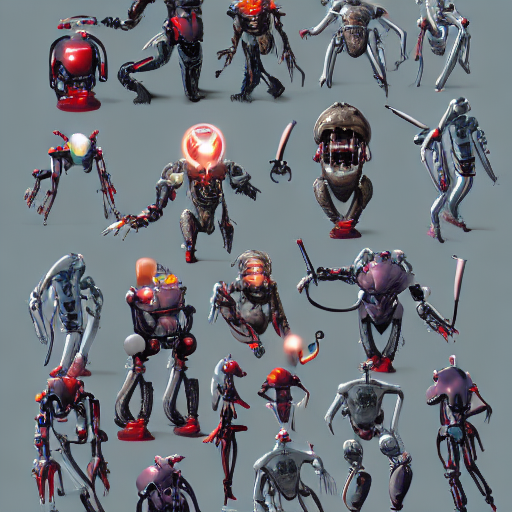

In [5]:
display(Image.fromarray(x_sample.astype(np.uint8)))